In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle
import tensorflow
from keras import applications
from keras import optimizers
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [2]:
foldernames = os.listdir('raw-img')
categories = []
files = []
i = 0
for k, folder in enumerate(foldernames):
    filenames = os.listdir("raw-img/" + folder);
    for file in filenames:
        files.append("raw-img/" + folder + "/" + file)
        categories.append(k)
        
df = pd.DataFrame({
    'filename': files,
    'category': categories
})
train_df = pd.DataFrame(columns=['filename', 'category'])
for i in range(10):
    train_df = train_df.append(df[df.category == i].iloc[:500,:])

train_df.head()
train_df = train_df.reset_index(drop=True)
train_df

,filename,category
0,raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg,0
1,raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS.jpeg,0
2,raw-img/cane/OIP---cByAiEbIxIAleGo9AqOQAAAA.jpeg,0
3,raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg,0
4,raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg,0
...,...,...
4995,raw-img/scoiattolo/OIP-DLuAMgbGGOGW0r49pIsMtgH...,9
4996,raw-img/scoiattolo/OIP-DlVY-0x9uqexVnZY_1TXxgH...,9
4997,raw-img/scoiattolo/OIP-DlwICIPtlrWDrdz6v-QVCQH...,9
4998,raw-img/scoiattolo/OIP-DL_IigTXGyMfa6OEnyQF3QH...,9


In [3]:
y = train_df['category']
x = train_df['filename']
y = train_df['category']

x, y = shuffle(x, y, random_state=8)

In [4]:
def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

images = []
with tqdm(total=len(train_df)) as pbar:
    for i, file_path in enumerate(train_df.filename.values):
        
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

       
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

       
        img = centering_image(cv2.resize(img, dsize=tile_size))

       
        img = img[16:240, 16:240]
        images.append(img)
        pbar.update(1)

images = np.array(images)

C:\Users\laksh\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/5000 [00:00<?, ?it/s]

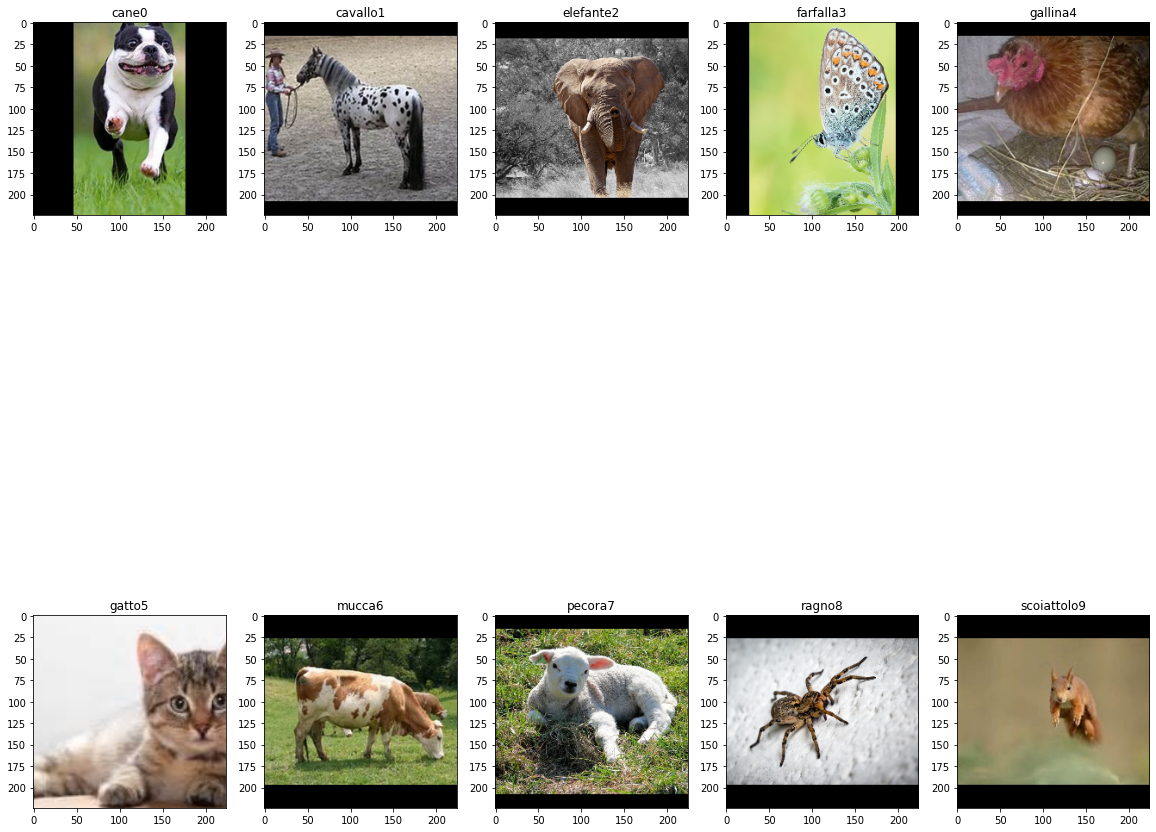

In [5]:
rows,cols = 2,5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))
for i in range(10):
    path = train_df[train_df.category == i].values[2]
#     image = cv2.imread(path[0])/
    axes[i//cols, i%cols].set_title(path[0].split('/')[-2] + str(path[1]))
    axes[i//cols, i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]])

In [6]:
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)
val_split_num = int(round(0.2*len(y)))
x_train = x[val_split_num:]
y_train = y[val_split_num:]
x_test = x[:val_split_num]
y_test = y[:val_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

img_rows, img_cols, img_channel = 224, 224, 3
name_animal = []
for i in range(10):
    path = train_df[train_df.category == i].values[2]
    if path[0].split('/')[-2] == 'scoiattolo':
        name_animal.append('squirrel')
    elif path[0].split('/')[-2] == 'cavallo':
        name_animal.append('horse')
    elif path[0].split('/')[-2] == 'farfalla':
        name_animal.append('butterfly')
    elif path[0].split('/')[-2] == 'mucca':
        name_animal.append('cow')
    elif path[0].split('/')[-2] == 'gatto':
        name_animal.append('cat')
    elif path[0].split('/')[-2] == 'pecora':
        name_animal.append('sheep')
    elif path[0].split('/')[-2] == 'gallina':
        name_animal.append('chicken')
    elif path[0].split('/')[-2] == 'elefante':
        name_animal.append('elephant')
    elif path[0].split('/')[-2] == 'ragno':
        name_animal.append('spider')
    elif path[0].split('/')[-2] == 'cane':
        name_animal.append('dog')

x_train (4000, 224, 224, 3)
y_train (4000,)
x_test (1000, 224, 224, 3)
y_test (1000,)


In [7]:
from sklearn.metrics import accuracy_score
from lib.utils import *
X,y=extract_feature(x_train)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
ac=[]

In [8]:
import tensorflow as tf
tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    
)
from keras.models import Sequential
from keras import layers
model = Sequential()
model.add(layers.Dense(20, input_dim=4, activation='relu'))
model.add(layers.Dense(10,  activation='tanh'))
model.add(layers.Dense(1024, activation='relu'))

model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              )
model.summary()
classifier_pnn = model.fit(X_train,y_train,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=15)
ac.append(accuracy_score(model,y_test,sample_weight=0.2)*100)

102981632/102967424 [==============================] - 17s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              11264     
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 16,695
Trainable params: 14,647
Non-trai

In [9]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(11,activation='relu',input_dim=4))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train,y_train,epochs=30)
ac.append(accuracy_score(model,y_test,sample_weight=1)*100)

Epoch 1/30
4/4 [==============================] - 0s 1ms/step - loss: 1.2810 - accuracy: 0.2500
Epoch 2/30
4/4 [==============================] - 0s 1ms/step - loss: 1.0861 - accuracy: 0.3400
Epoch 3/30
4/4 [==============================] - 0s 2ms/step - loss: 0.9257 - accuracy: 0.3500
Epoch 4/30
4/4 [==============================] - 0s 2ms/step - loss: 0.7963 - accuracy: 0.3500
Epoch 5/30
4/4 [==============================] - 0s 3ms/step - loss: 0.6705 - accuracy: 0.3500
Epoch 6/30
4/4 [==============================] - 0s 3ms/step - loss: 0.5828 - accuracy: 0.3500
Epoch 7/30
4/4 [==============================] - 0s 2ms/step - loss: 0.4898 - accuracy: 0.3500
Epoch 8/30
4/4 [==============================] - 0s 3ms/step - loss: 0.4135 - accuracy: 0.3500
Epoch 9/30
4/4 [==============================] - 0s 4ms/step - loss: 0.3425 - accuracy: 0.3500
Epoch 10/30
4/4 [==============================] - 0s 3ms/step - loss: 0.2870 - accuracy: 0.3500
Epoch 11/30
4/4 [======================

In [10]:
import cv2
import numpy as np
labelsPath = "coco.names"
labelsPath = "coco.names"
classes = open(labelsPath).read().strip().split("\n")


net = cv2.dnn.readNetFromDarknet("yolov3-tiny.cfg","yolov3-tiny.weights")
final_classes = ['bird', 'cat', 'dog', 'sheep', 'horse', 'cow', 'elephant', 'zebra', 'bear', 'giraffe']

cap = cv2.VideoCapture('test.mp4')
font = cv2.FONT_HERSHEY_PLAIN
colors = np.random.uniform(0, 255, size=(100, 3))

while True:
    _, img = cap.read()
    height, width, _ = img.shape

    blob = cv2.dnn.blobFromImage(img, 1/255, (416, 416), (0,0,0), swapRB=True, crop=False)
    net.setInput(blob)
    output_layers_names = net.getUnconnectedOutLayersNames()
    layerOutputs = net.forward(output_layers_names)

    boxes = []
    confidences = []
    class_ids = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.2:
                center_x = int(detection[0]*width)
                center_y = int(detection[1]*height)
                w = int(detection[2]*width)
                h = int(detection[3]*height)

                x = int(center_x - w/2)
                y = int(center_y - h/2)

                boxes.append([x, y, w, h])
                confidences.append((float(confidence)))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4)

    if(len(indexes)>0):
        for i in indexes.flatten():
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            if(label in final_classes):
                confidence = str(round(confidences[i],2))
                color = colors[i]
                cv2.rectangle(img, (x,y), (x+w, y+h), color, 2)
                cv2.putText(img, label + " " + confidence, (x, y+20), font, 2, (255,255,255), 2)

    cv2.imshow('Image', img)
    key = cv2.waitKey(1)
    if key==27:
        break

cap.release()
cv2.destroyAllWindows()

the accuracy of Resnet50 is 94.77 and CNN is 92.89


C:\Users\laksh\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,Agorithms,accuracy
0,Resnet50,94.77
1,CNN,92.89


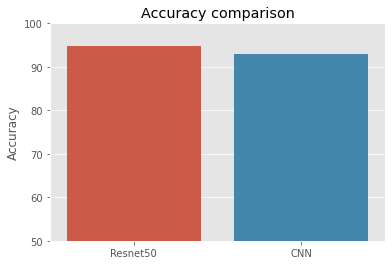

In [11]:
import numpy as np
import seaborn as sns
import matplotlib as plt

plt.style.use('ggplot')
x=['Resnet50','CNN']
 
ax=sns.barplot(x,ac[:2])
ax.set_title('Accuracy comparison')
ax.set_ylabel('Accuracy')
#ax.yaxis.set_major_locator(ticker.LinearLocator())
print("the accuracy of {} is {} and {} is {}".format(x[0],ac[0],x[1],ac[1]))
ax.set_ylim(50,100)
import pandas as pd
data={'Agorithms':x,
     "accuracy":ac}
df=pd.DataFrame(data)
df.head()